In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


### TODO LIST

> * put feature enginering into function to be able to use both test and train data set.
* copy and use plot decision boundary function from this (https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/02_neural_network_classification_in_tensorflow.ipynb) notebook to see how my simple dense model fails
> * find out the relationship between the `SibSp` and the `Parch` column.
* create more tf models for eg.> Conv1D, LSTM .... to get more experience.

In [11]:
pd.set_option('display.max_rows', 500)

### Imports

In [12]:
# Library imports
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import os

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model evaluators
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

# tensorflow related imports
from tensorflow.keras.layers import IntegerLookup, Normalization, StringLookup 
print(tf.__version__)

2.6.4


### Helper Functions

In [13]:
def create_model_checkpoint(model_name, save_path="model_experiment"):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(save_path, model_name), 
        verbose=1, 
        save_best_only=True,
        monitor='val_accuracy',
    )

In [45]:
scaler = MinMaxScaler()


def feature_handler(data_frame, feature_importance=False, is_performance_model=False):
    if is_performance_model:
        # remove uneccessary columns
        data_frame = train_df.drop(labels=["Cabin","Name", "Ticket"], axis=1)
        # fill missing data
        data_frame["Age"] = data_frame["Age"].fillna(data_frame["Age"].mean())
        data_frame["Embarked"] = data_frame["Embarked"].fillna("S")
        data_frame["Fare"] = data_frame["Fare"].fillna(data_frame['Fare'].mean())
        # creating new columns
        data_frame["Is_Child"] = np.where(data_frame["Age"] < 12 , 1 , 0)
        # to remove Passanger ID turn into index
        data_frame.set_index(keys="PassengerId", inplace=True)
    else:
        data_frame = data_frame.copy()
        data_frame = data_frame.set_index("PassengerId")
        data_frame = data_frame.drop(labels=["Cabin", "Name", "Ticket"], axis=1)
        encoded_sex = pd.get_dummies(data_frame.Sex, prefix="sex")
        encoded_Pclass = pd.get_dummies(data_frame.Pclass, prefix="Pclass")
        encoded_Embarked = pd.get_dummies(data_frame.Embarked, prefix="Embarked")

        data_frame = pd.concat([data_frame,encoded_sex, encoded_Pclass, encoded_Embarked], axis=1)
        data_frame["Family"] = np.where((data_frame["SibSp"] > 0) |(data_frame['Parch'] > 0) , 1, 0)
        data_frame["Embarked"] = data_frame["Embarked"].fillna("S", inplace=True)    
        data_frame = data_frame.drop(["Sex", "Pclass", "Embarked", "SibSp", "Parch"], axis=1)
        data_frame["Age"] = data_frame["Age"].fillna(data_frame["Age"].mean())
        data_frame["Fare"] = data_frame["Fare"].fillna(data_frame['Fare'].mean())
        data_frame[['Age', 'Fare']] = scaler.fit_transform(data_frame[['Age', 'Fare']])

        if feature_importance:
            data_frame = data_frame.drop(["Pclass_1", "Pclass_2", "Embarked_C", "Embarked_Q", "Embarked_S", "Family"], axis=1)

        data_frame.info()
    return data_frame

In [15]:
def plot_decision_boundary(model, X, y):
  """
  Plots the decision boundary created by a model predicting on X.
  This function has been adapted from two phenomenal resources:
   1. CS231n - https://cs231n.github.io/neural-networks-case-study/
   2. Made with ML basics - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
  """
  # Define the axis boundaries of the plot and create a meshgrid
  print(X.shape)
  print(y.shape)
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))
  
  # Create X values (we're going to predict on all of these)
  x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together: https://numpy.org/devdocs/reference/generated/numpy.c_.html
  
  # Make predictions using the trained model
  y_pred = model.predict(x_in)

  # Check for multi-class
  if model.output_shape[-1] > 1: # checks the final dimension of the model's output shape, if this is > (greater than) 1, it's multi-class 
    print("doing multiclass classification...")
    # We have to reshape our predictions to get them ready for plotting
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
  else:
    print("doing binary classifcation...")
    y_pred = np.round(np.max(y_pred, axis=1)).reshape(xx.shape)
  
  # Plot decision boundary
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

In [16]:
def fit_and_score (models, X_train, X_val, y_train, y_val ):
    np.random.seed(883)
    model_scores= {}
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_val, y_val)
    return model_scores

In [17]:
def dataframe_to_dataset (dataframe, is_test):
    data_frame = dataframe.copy()
    if is_test:
        ds = tf.data.Dataset.from_tensors(dict(data_frame))
    else:    
        labels = data_frame.pop("Survived")
        ds = tf.data.Dataset.from_tensor_slices((dict(data_frame), labels))
        ds = ds.shuffle(buffer_size=len(data_frame))
    return ds

In [18]:
def encode_numerical_feature (feature, name, dataset):
    normalizer = Normalization()
    
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
    
    normalizer.adapt(feature_ds)
    encoded_feature = normalizer(feature)
    return encoded_feature

In [19]:
def encode_categorical_feature (feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    lookup = lookup_class(output_mode="binary")
    
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
    
    lookup.adapt(feature_ds)
    encoded_feature = lookup(feature)
    return encoded_feature

In [20]:
# def is_child (age):
     

### Data section

Two types of data sets were created. The first one is a simple cleard data set the second one contains fewer features based on the RandomForestClassifier.feature_importance function.

In [21]:
# Imports dataset from Kaggle
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
len(train_df), len(test_df), train_df.shape, test_df.shape

(891, 418, (891, 12), (418, 11))

In [59]:
train_df[:10]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [60]:
df = feature_handler(train_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Age         891 non-null    float64
 2   Fare        891 non-null    float64
 3   sex_female  891 non-null    uint8  
 4   sex_male    891 non-null    uint8  
 5   Pclass_1    891 non-null    uint8  
 6   Pclass_2    891 non-null    uint8  
 7   Pclass_3    891 non-null    uint8  
 8   Embarked_C  891 non-null    uint8  
 9   Embarked_Q  891 non-null    uint8  
 10  Embarked_S  891 non-null    uint8  
 11  Family      891 non-null    int64  
dtypes: float64(2), int64(2), uint8(8)
memory usage: 41.8 KB


In [61]:
df_test = feature_handler(test_df)
df_test.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         418 non-null    float64
 1   Fare        418 non-null    float64
 2   sex_female  418 non-null    uint8  
 3   sex_male    418 non-null    uint8  
 4   Pclass_1    418 non-null    uint8  
 5   Pclass_2    418 non-null    uint8  
 6   Pclass_3    418 non-null    uint8  
 7   Embarked_C  418 non-null    uint8  
 8   Embarked_Q  418 non-null    uint8  
 9   Embarked_S  418 non-null    uint8  
 10  Family      418 non-null    int64  
dtypes: float64(2), int64(1), uint8(8)
memory usage: 16.3 KB


Age           0
Fare          0
sex_female    0
sex_male      0
Pclass_1      0
Pclass_2      0
Pclass_3      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
Family        0
dtype: int64

In [62]:
df_less = feature_handler(train_df, feature_importance=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Age         891 non-null    float64
 2   Fare        891 non-null    float64
 3   sex_female  891 non-null    uint8  
 4   sex_male    891 non-null    uint8  
 5   Pclass_3    891 non-null    uint8  
dtypes: float64(2), int64(1), uint8(3)
memory usage: 30.5 KB


In [63]:
df_less_test = feature_handler(test_df, feature_importance=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         418 non-null    float64
 1   Fare        418 non-null    float64
 2   sex_female  418 non-null    uint8  
 3   sex_male    418 non-null    uint8  
 4   Pclass_3    418 non-null    uint8  
dtypes: float64(2), uint8(3)
memory usage: 11.0 KB


### Expoloring Data

<AxesSubplot:>

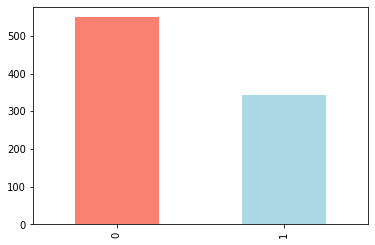

In [64]:
df["Survived"].value_counts().plot(kind="bar", color=["salmon", "lightblue"])

In [65]:
df.describe()

,Survived,Age,Fare,sex_female,sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Family
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,0.367921,0.062858,0.352413,0.647587,0.242424,0.206510,0.551066,0.188552,0.086420,0.722783,0.397306
std,0.486592,0.163383,0.096995,0.477990,0.477990,0.428790,0.405028,0.497665,0.391372,0.281141,0.447876,0.489615
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.271174,0.015440,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.367921,0.028213,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,0.434531,0.060508,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [66]:
df.isna().sum()

Survived      0
Age           0
Fare          0
sex_female    0
sex_male      0
Pclass_1      0
Pclass_2      0
Pclass_3      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
Family        0
dtype: int64

In [67]:
df[:10]

,Survived,Age,Fare,sex_female,sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Family
PassengerId,,,,,,,,,,,,
1,0,0.271174,0.014151,0,1,0,0,1,0,0,1,1
2,1,0.472229,0.139136,1,0,1,0,0,1,0,0,1
3,1,0.321438,0.015469,1,0,0,0,1,0,0,1,0
4,1,0.434531,0.103644,1,0,1,0,0,0,0,1,1
5,0,0.434531,0.015713,0,1,0,0,1,0,0,1,0
6,0,0.367921,0.016510,0,1,0,0,1,0,1,0,0
7,0,0.673285,0.101229,0,1,1,0,0,0,0,1,0
8,0,0.019854,0.041136,0,1,0,0,1,0,0,1,1
9,1,0.334004,0.021731,1,0,0,0,1,0,0,1,1


(12.5, -0.5)

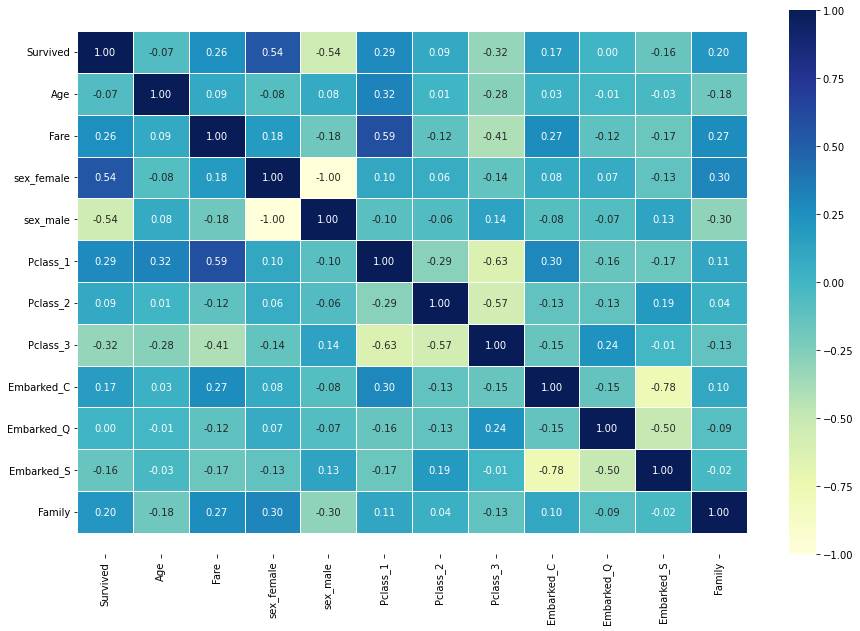

In [68]:
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(
            corr_matrix,
            annot=True,
            linewidths=0.5,
            fmt=".2f",
            cmap="YlGnBu"
)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

### Creating Train and Test Split

In order to be able to test both versions of data sets (feature importance filtered fewer data and the base data set) two versions of X, and y data were created. 

In [69]:
X = df.drop("Survived", axis=1)
y = df["Survived"]
X_less = df_less.drop("Survived", axis=1)
y_less = df_less["Survived"]

In [70]:
# Original data set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=883)
len(X_train), len(X_val), len(y_train), len(y_val)

(712, 179, 712, 179)

In [71]:
# Feature importance based data set
X_train_less, X_val_less, y_train_less, y_val_less = train_test_split(X_less, y_less, test_size=0.2, random_state=883)
len(X_train_less), len(X_val_less), len(y_train_less), len(y_val_less)

(712, 179, 712, 179)

# Modelling

### BASELINE_models

In [72]:
models = {
    "KNN": KNeighborsClassifier(),
    "Linear": LogisticRegression(),
    "RFC": RandomForestClassifier()
}

model_scores = fit_and_score(models=models, 
                          X_train=X_train, 
                          X_val=X_val, 
                          y_train=y_train, 
                          y_val=y_val)
model_scores

{'KNN': 0.7206703910614525,
 'Linear': 0.7206703910614525,
 'RFC': 0.7486033519553073}

### MODEL_1: Random Forest Classifier

In [ ]:
# initial parameter to GridSearchCV
params = {
    'bootstrap': [True],
    'max_depth': [80, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 5],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 500, 1000]
}

# creating model
model_1_rfc = RandomForestClassifier()

GS_model_1_rfc = GridSearchCV(estimator=model_1_rfc,
                     param_grid=params,
                     cv=5)

# fit the model
GS_model_1_rfc.fit(X_train, y_train)

# pick the best model 
model_1_rfc_best = GS_model_1_rfc.best_estimator_
print(model_1_rfc_best)

# evaluate on validation data
print(model_1_rfc_best.score(X_val, y_val))

# predict
model_1_predictions = model_1_rfc_best.predict(df_test)


In [ ]:
# get the feature importance see the bigger picture
feature_importance = model_1_rfc_best.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_1_rfc_best.estimators_], axis=0)
feature_names = [i for i in X_train]

forest_importances = pd.Series(feature_importance, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
# print(classification_report(y_test, y_preds))

### Model_2: Random Forest Classifier 
**trained on less data with feature importance**

In [ ]:
# create model 
model_2_rfc = RandomForestClassifier()
GS_model_2_rfc = GridSearchCV(estimator=model_2_rfc, 
                              cv=5, 
                              param_grid=params )

# fit the model on less more important features
GS_model_2_rfc.fit(X_train_less, y_train_less )

# pick the best estimator
model_2_rfc_fi_best = GS_model_2_rfc.best_estimator_

# evaluate the model on validation data
model_2_rfc_fi_best.score(X_val_less, y_val_less)

# predict on Kaggle test data
model_2_predictions = model_2_rfc_fi_best.predict(df_less_test)

### MODEL_3: Simple DENSE model

In [ ]:
tf.random.set_seed(883)
input_shape = X_train.shape[1]

# creating the simple dense model
# it is a very simple explonatory model with almost random layers and neurons
# this model works as a tensorflow baseline model
model_3_sdense = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(1,input_shape)),
    tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(256, activation=tf.keras.activations.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(256, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

# compile the simple dense model
model_3_sdense.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ]
)

# fit the simple dense model
model_3_sdense.fit(X_train, y_train, epochs=100, validation_data=(X_val,y_val), callbacks=[create_model_checkpoint("model_3_sdense")])

In [ ]:
# load the best model and evaluate the result
model_3_sdense_best = tf.keras.models.load_model("./model_experiment/model_3_sdense/")
model_3_sdense_best.evaluate(X_val, y_val)

In [ ]:
model_3_predictions = model_3_sdense_best.predict(df_test)
model_3_predictions = tf.cast(np.round(np.max(model_3_predictions, axis=1)), dtype=tf.int32)

### MODEL_4: Binary Classification Model to Structured Data
[https://keras.io/examples/structured_data/structured_data_classification_from_scratch/](http://)

In [53]:
titanic_data_frame = feature_handler(train_df, is_performance_model=True)
test_data_frame = feature_handler(test_df, is_performance_model=True)
val_dataframe = titanic_data_frame.sample(frac=0.2, random_state=883)
train_dataframe = titanic_data_frame.drop(val_dataframe.index)

In [54]:
# Turn datafram into dataset
train_ds = dataframe_to_dataset(train_dataframe, False)
val_ds = dataframe_to_dataset(val_dataframe, False)
test_ds = dataframe_to_dataset(test_data_frame, True)
# test_ds = tf.data.Dataset.from_tensors(dict(test_data_frame))

In [55]:
# peek into the dataset
# print(list(train_ds.as_numpy_iterator()))
for x, y in train_ds.take(1):
    print(f"Input: {x}")
    print(f"Target: {y}")

Input: {'Pclass': <tf.Tensor: shape=(), dtype=int64, numpy=3>, 'Sex': <tf.Tensor: shape=(), dtype=string, numpy=b'male'>, 'Age': <tf.Tensor: shape=(), dtype=float64, numpy=24.5>, 'SibSp': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'Parch': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'Fare': <tf.Tensor: shape=(), dtype=float64, numpy=8.05>, 'Embarked': <tf.Tensor: shape=(), dtype=string, numpy=b'S'>, 'Is_Child': <tf.Tensor: shape=(), dtype=int64, numpy=0>}
Target: 0


In [56]:
train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)
# test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)
train_ds, test_ds

(<PrefetchDataset shapes: ({Pclass: (None,), Sex: (None,), Age: (None,), SibSp: (None,), Parch: (None,), Fare: (None,), Embarked: (None,), Is_Child: (None,)}, (None,)), types: ({Pclass: tf.int64, Sex: tf.string, Age: tf.float64, SibSp: tf.int64, Parch: tf.int64, Fare: tf.float64, Embarked: tf.string, Is_Child: tf.int64}, tf.int64)>,
 <TensorDataset shapes: {Survived: (891,), Pclass: (891,), Sex: (891,), Age: (891,), SibSp: (891,), Parch: (891,), Fare: (891,), Embarked: (891,), Is_Child: (891,)}, types: {Survived: tf.int64, Pclass: tf.int64, Sex: tf.string, Age: tf.float64, SibSp: tf.int64, Parch: tf.int64, Fare: tf.float64, Embarked: tf.string, Is_Child: tf.int64}>)

In [57]:
titanic_data_frame[:20]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Is_Child
PassengerId,,,,,,,,,
1,0,3,male,22.000000,1,0,7.2500,S,0
2,1,1,female,38.000000,1,0,71.2833,C,0
3,1,3,female,26.000000,0,0,7.9250,S,0
4,1,1,female,35.000000,1,0,53.1000,S,0
5,0,3,male,35.000000,0,0,8.0500,S,0
6,0,3,male,29.699118,0,0,8.4583,Q,0
7,0,1,male,54.000000,0,0,51.8625,S,0
8,0,3,male,2.000000,3,1,21.0750,S,1
9,1,3,female,27.000000,0,2,11.1333,S,0


In [58]:
# categorical feature encoding as int
pclass = tf.keras.Input(shape=(1,), name="Pclass", dtype=tf.int64)
ischild = tf.keras.Input(shape=(1,), name="Is_Child", dtype=tf.int64)

# categorical feature encoding as string
sex = tf.keras.Input(shape=(1,), name="Sex", dtype=tf.string)
embarked = tf.keras.Input(shape=(1,), name="Embarked", dtype=tf.string)

# numerical feature encoding

age = tf.keras.Input(shape=(1,), name="Age")
sibsp = tf.keras.Input(shape=(1,), name="SibSp")
parch = tf.keras.Input(shape=(1,), name="Parch")
fare = tf.keras.Input(shape=(1,), name="Fare")

all_inputs = [
    pclass,
    sex,
    embarked,
    age,
    sibsp,
    parch,
    fare,
    ischild
]

# string categorical features
sex_encoded = encode_categorical_feature(sex, "Sex", train_ds, True)
embarked_encoded = encode_categorical_feature(embarked, "Embarked", train_ds, True)

# int categorical features
pclass_encoded = encode_categorical_feature(pclass, "Pclass", train_ds, False)
ischild_encoded = encode_categorical_feature(ischild, "Is_Child", train_ds, False)

# numerical features
age_encoded = encode_numerical_feature(age, "Age", train_ds)
sibsp_encoded = encode_numerical_feature(sibsp, "SibSp", train_ds)
parch_encoded = encode_numerical_feature(parch, "Parch", train_ds)
fare_encoded = encode_numerical_feature(fare, "Fare", train_ds)

all_features = tf.keras.layers.concatenate([
    sex_encoded,
    embarked_encoded,
    pclass_encoded,
    age_encoded,
    sibsp_encoded,
    parch_encoded,
    fare_encoded,
    ischild_encoded
])

x = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu)(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)(x)
model_4 = tf.keras.Model(all_inputs, output)
model_4.compile(optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'], loss=tf.keras.losses.binary_crossentropy)

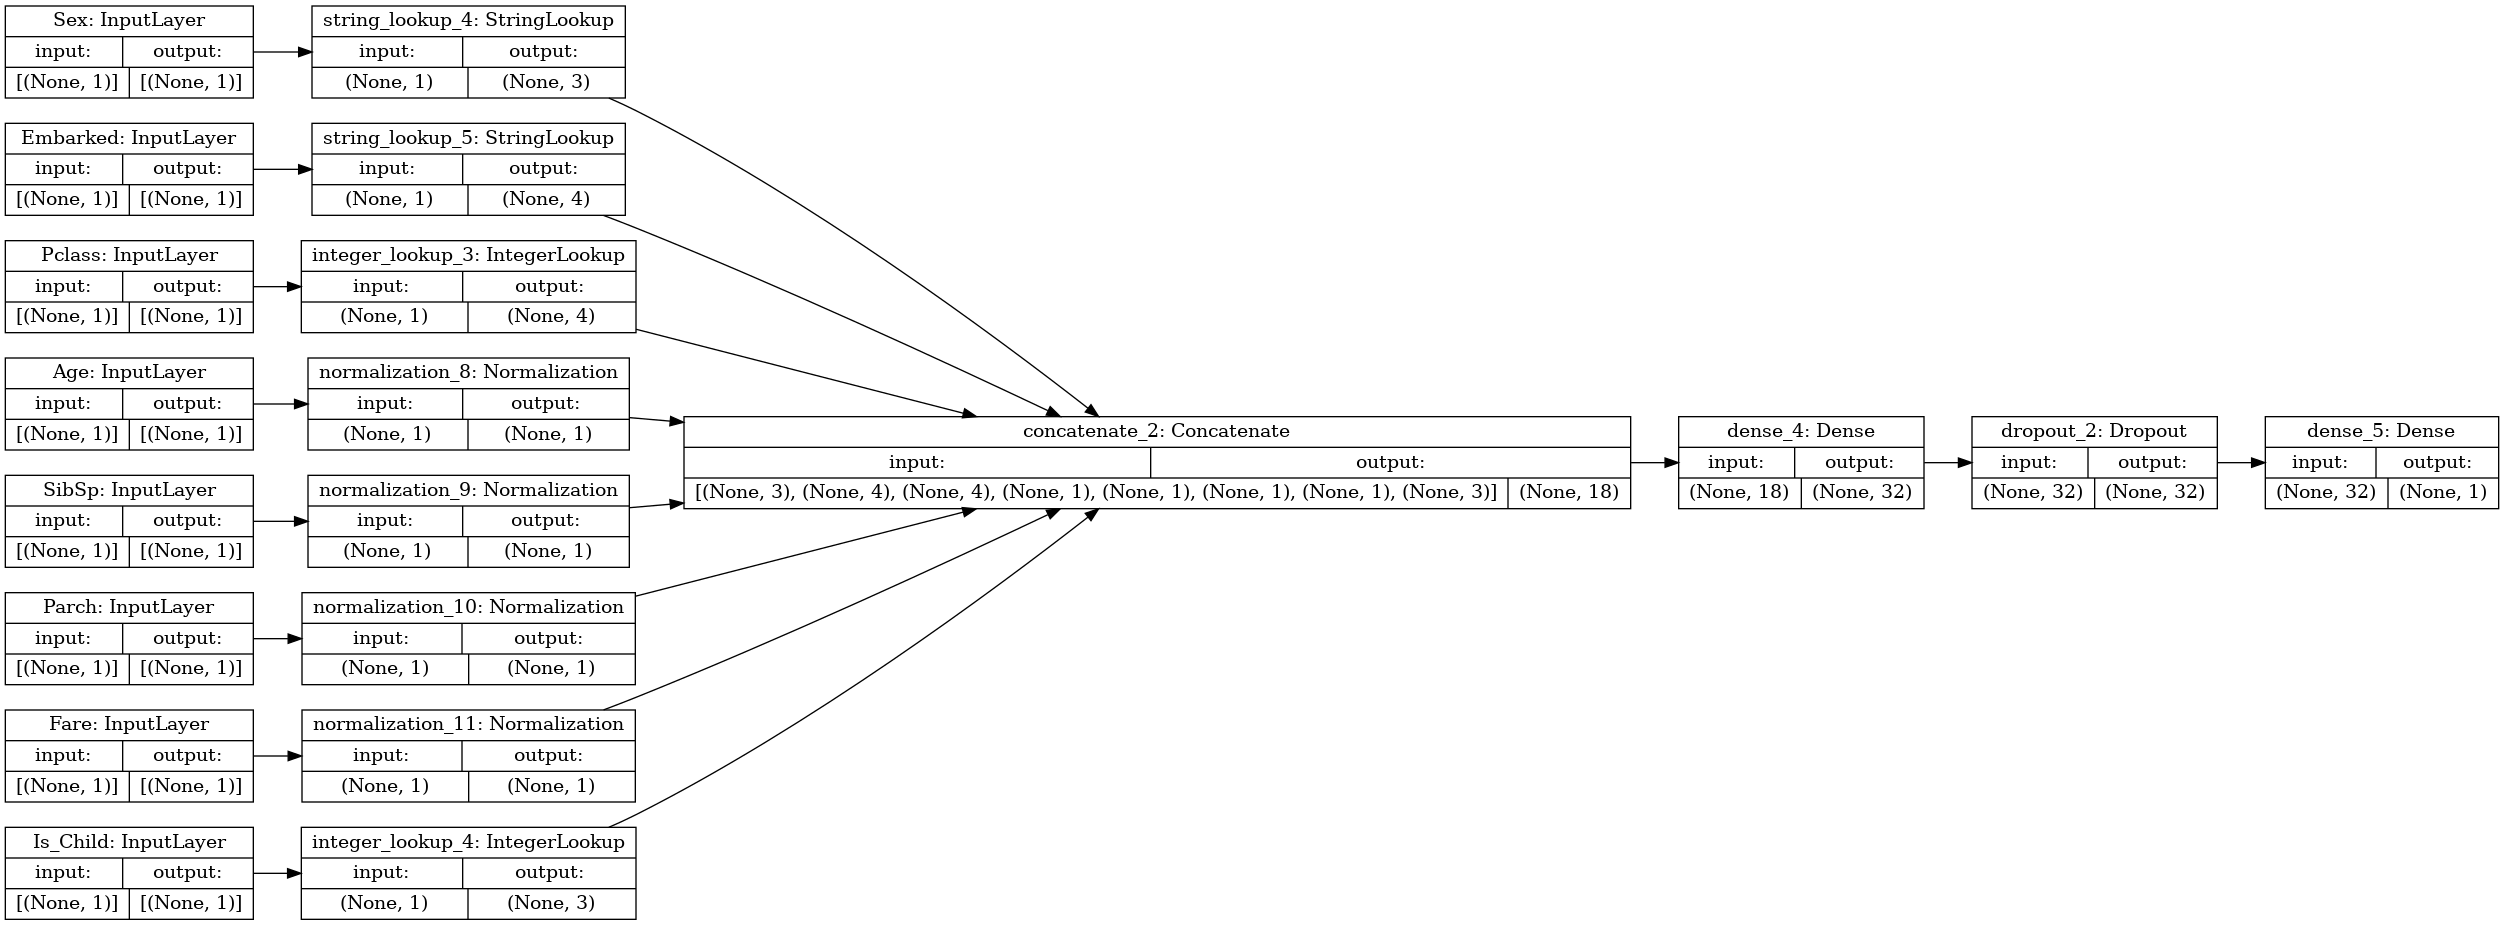

In [59]:
tf.keras.utils.plot_model(model_4, show_shapes=True, rankdir="LR")

In [66]:
model_4.fit(train_ds, epochs=1000, validation_data=val_ds, callbacks=[create_model_checkpoint("model_4")])

Epoch 1/1000
23/23 [==============================] - 0s 3ms/step - loss: 0.4711 - accuracy: 0.8008 - val_loss: 0.5181 - val_accuracy: 0.7528

Epoch 00001: val_accuracy improved from -inf to 0.75281, saving model to model_experiment/model_4
Epoch 2/1000
23/23 [==============================] - 0s 3ms/step - loss: 0.4848 - accuracy: 0.7938 - val_loss: 0.5184 - val_accuracy: 0.7584

Epoch 00002: val_accuracy improved from 0.75281 to 0.75843, saving model to model_experiment/model_4
Epoch 3/1000
23/23 [==============================] - 0s 3ms/step - loss: 0.4623 - accuracy: 0.8065 - val_loss: 0.5162 - val_accuracy: 0.7472

Epoch 00003: val_accuracy did not improve from 0.75843
Epoch 4/1000
23/23 [==============================] - 0s 3ms/step - loss: 0.4583 - accuracy: 0.7980 - val_loss: 0.5168 - val_accuracy: 0.7528

Epoch 00004: val_accuracy did not improve from 0.75843
Epoch 5/1000
23/23 [==============================] - 0s 3ms/step - loss: 0.4481 - accuracy: 0.8149 - val_loss: 0.5169 

In [67]:
model_4_best = tf.keras.models.load_model("./model_experiment/model_4/")
model_4_best.evaluate(val_ds)

6/6 [==============================] - 0s 2ms/step - loss: 0.5104 - accuracy: 0.7921


[0.5104111433029175, 0.7921348214149475]

In [62]:
test_data_frame.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Is_Child
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,0
2,1,1,female,38.0,1,0,71.2833,C,0
3,1,3,female,26.0,0,0,7.9250,S,0
4,1,1,female,35.0,1,0,53.1000,S,0
5,0,3,male,35.0,0,0,8.0500,S,0


In [63]:
test_ds

<TensorDataset shapes: {Survived: (891,), Pclass: (891,), Sex: (891,), Age: (891,), SibSp: (891,), Parch: (891,), Fare: (891,), Embarked: (891,), Is_Child: (891,)}, types: {Survived: tf.int64, Pclass: tf.int64, Sex: tf.string, Age: tf.float64, SibSp: tf.int64, Parch: tf.int64, Fare: tf.float64, Embarked: tf.string, Is_Child: tf.int64}>

In [68]:
model_4_predictions = model_4_best.predict(test_ds)
model_4_predictions = tf.cast(np.round(np.max(model_4_predictions, axis=1)), dtype=tf.int32)  
model_4_predictions

/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['Survived'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


<tf.Tensor: shape=(891,), dtype=int32, numpy=
array([0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
     

# Creating output to submit result

In [69]:
output = pd.DataFrame({"PassengerId": test_data_frame.index, "Survived": model_4_predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
